In [1]:
trial_number_ml = "006"
random_state_init = 666

In [2]:
# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# optuna
import optuna
import optuna.integration.lightgbm as lgb_optuna
from optuna.pruners import MedianPruner
from optuna.integration import OptunaSearchCV

#xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance


# metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, make_scorer, precision_recall_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold

#lightgbm
import lightgbm as lgb
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns


from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole # Enables RDKit's IPython integration for Jupyter notebooks.
from IPython.display import display


import os
from rdkit.Chem.Draw import rdMolDraw2D

import joblib


# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
import os

# Get the current working directory
current_dir = os.getcwd()
print("Current Directory:", current_dir)

# Verify the change
new_dir = os.getcwd()
print("New Working Directory:", new_dir)


Current Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model1_rna_b_rna_n
New Working Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model1_rna_b_rna_n


In [4]:
def load_and_concatenate_datasets(file_paths):
    """
    Load datasets from given file paths and concatenate them into a single DataFrame.
    """
    dataframes = [pd.read_pickle(path) for path in file_paths]
    return pd.concat(dataframes, ignore_index=True)

def preprocess_data(df, feature_col='ecfp6', label_col='label'):
    """
    Preprocess the DataFrame by extracting features and labels.
    """
    X = np.array([list(map(int, list(fp))) for fp in df[feature_col]])
    y = df[label_col].values
    return X, y

def stratified_train_test_split(X, y, test_size=0.2, random_state=42):
    """
    Split the dataset into training and test sets, ensuring stratification of the target variable.
    """
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# Paths for the datasets
model1_files = ['../../data_for_ml/ml_datasets_set2/model1_rna_bin_non_rna_bin/data.pkl']

# Load datasets
model1_df = load_and_concatenate_datasets(model1_files)

# Preprocess datasets
X1, y1 = preprocess_data(model1_df)

# Split datasets
X_train, X_test, y_train, y_test = stratified_train_test_split(X1, y1)

# Output shapes
print(f"Model 1 - Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")


Model 1 - Training set size: 3137, Test set size: 785


In [5]:
import numpy as np
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from optuna.integration import OptunaSearchCV


def model_training_and_evaluation(model, X_train, y_train, X_test, y_test):
    """
    Train and evaluate a model using given datasets.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return model, accuracy

def objective(trial, model_cls, X_train, y_train):
    """
    Objective function for hyperparameter tuning with Optuna.
    
    Args:
    - trial (optuna.trial.Trial): An individual trial object.
    - model_cls: The classifier class to be optimized.
    - X_train, y_train: Training data.
    
    Returns:
    - The accuracy of the model on the cross-validation folds.
    """
    # Suggest hyperparameters specific to the RandomForestClassifier
    if model_cls == RandomForestClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        max_depth = trial.suggest_int('max_depth', 10, 100)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        
        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                          min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                          max_features=max_features, random_state=random_state_init, n_jobs=4)
        
    elif model_cls == XGBClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, log=True)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
        subsample = trial.suggest_float('subsample', 0.5, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
        gamma = trial.suggest_float('gamma', 0, 5)
        reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10.0, log=True)
        reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10.0, log=True)

        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                        learning_rate=learning_rate, min_child_weight=min_child_weight,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        gamma=gamma, reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                        random_state=random_state_init, use_label_encoder=False, eval_metric='logloss', n_jobs=4)
    
    elif model_cls == LGBMClassifier:
        boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss'])
        num_leaves = trial.suggest_int('num_leaves', 31, 100)
        max_depth = trial.suggest_int('max_depth', -1, 15)
        learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5)
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        min_child_weight = trial.suggest_float('min_child_weight', 1e-3, 1e-1, log=True)
        min_child_samples = trial.suggest_int('min_child_samples', 20, 2000)
        subsample = trial.suggest_float('subsample', 0.8, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.8, 1.0)
        reg_alpha = trial.suggest_float('reg_alpha', 1e-10, 1.0, log=True)
        reg_lambda = trial.suggest_float('reg_lambda', 1e-10, 1.0, log=True)
        
        model = model_cls(boosting_type=boosting_type, num_leaves=num_leaves, max_depth=max_depth,
                        learning_rate=learning_rate, n_estimators=n_estimators,
                        min_child_weight=min_child_weight, min_child_samples=min_child_samples,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        reg_alpha=reg_alpha, reg_lambda=reg_lambda, random_state=random_state_init, verbosity=-1, n_jobs=4)
    else:
        raise NotImplementedError("Optuna objective function needs to be extended for other classifiers.")
    
    # Cross-validation within the Optuna trial
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state_init)
    accuracies = []
    for train_index, val_index in stratified_kfold.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        model.fit(X_fold_train, y_fold_train)
        y_fold_pred = model.predict(X_fold_val)
        accuracy = accuracy_score(y_fold_val, y_fold_pred)
        accuracies.append(accuracy)
        
        trial.report(np.mean(accuracies), len(accuracies))
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return np.mean(accuracies)

def perform_hyperparameter_tuning(model_cls, X_train, y_train, n_trials=50):
    """
    Perform hyperparameter tuning for the given model class using Optuna.
    """
    study = optuna.create_study(direction='maximize')
    objective_with_model = lambda trial: objective(trial, model_cls, X_train, y_train)
    study.optimize(objective_with_model, n_trials=n_trials, n_jobs=4) 
    
    print(f"Best trial for {model_cls.__name__}:")
    print(f"  Value: {study.best_trial.value}")
    print("  Params: ")
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")
    print('')
    return study.best_params

print('')
# Example usage for RandomForestClassifier
best_params_rf = perform_hyperparameter_tuning(RandomForestClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for RandomForestClassifier:", best_params_rf)
# Train and evaluate the final model with the best hyperparameters
best_rf = RandomForestClassifier(**best_params_rf, random_state=random_state_init)
final_model, final_accuracy = model_training_and_evaluation(best_rf, X_train, y_train, X_test, y_test)
print(f"RandomForestClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for XGBClassifier
best_params_xgb = perform_hyperparameter_tuning(XGBClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for XGBClassifier:", best_params_xgb)
# Train and evaluate the final model with the best hyperparameters
best_xgb = XGBClassifier(**best_params_xgb, random_state=random_state_init, use_label_encoder=False, eval_metric='logloss')
final_model, final_accuracy = model_training_and_evaluation(best_xgb, X_train, y_train, X_test, y_test)
print(f"XGBClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for LGBMClassifier
best_params_lgb = perform_hyperparameter_tuning(LGBMClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for LGBMClassifier:", best_params_lgb)
# Train and evaluate the final model with the best hyperparameters
best_lgb = LGBMClassifier(**best_params_lgb, random_state=random_state_init, verbosity=-1)
final_model, final_accuracy = model_training_and_evaluation(best_lgb, X_train, y_train, X_test, y_test)
print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")

print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")
print('')


[I 2024-05-01 16:41:27,103] A new study created in memory with name: no-name-b9481bc2-95a7-4191-990e-bf91ed3a08f7


[I 2024-05-01 16:42:39,378] Trial 1 finished with value: 0.6279899226932415 and parameters: {'n_estimators': 370, 'max_depth': 55, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 1 with value: 0.6279899226932415.


[I 2024-05-01 16:42:45,356] Trial 2 finished with value: 0.6213015166753014 and parameters: {'n_estimators': 477, 'max_depth': 48, 'min_samples_split': 19, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 1 with value: 0.6279899226932415.


[I 2024-05-01 16:43:27,480] Trial 3 finished with value: 0.6209825374089537 and parameters: {'n_estimators': 720, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6279899226932415.


[I 2024-05-01 16:43:47,445] Trial 5 finished with value: 0.6248062251749815 and parameters: {'n_estimators': 333, 'max_depth': 75, 'min_samples_split': 14, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6279899226932415.


[I 2024-05-01 16:44:13,006] Trial 4 finished with value: 0.6165224148965349 and parameters: {'n_estimators': 636, 'max_depth': 100, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 1 with value: 0.6279899226932415.


[I 2024-05-01 16:44:16,675] Trial 7 pruned. 


[I 2024-05-01 16:44:24,931] Trial 9 pruned. 


[I 2024-05-01 16:44:27,540] Trial 0 finished with value: 0.623211328843243 and parameters: {'n_estimators': 987, 'max_depth': 94, 'min_samples_split': 7, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6279899226932415.


[I 2024-05-01 16:44:40,875] Trial 10 pruned. 


[I 2024-05-01 16:45:03,789] Trial 6 finished with value: 0.626716037342923 and parameters: {'n_estimators': 503, 'max_depth': 94, 'min_samples_split': 18, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6279899226932415.


[I 2024-05-01 16:45:07,913] Trial 13 pruned. 


[I 2024-05-01 16:45:16,257] Trial 12 pruned. 


[I 2024-05-01 16:45:30,721] Trial 8 finished with value: 0.6260821422403723 and parameters: {'n_estimators': 447, 'max_depth': 19, 'min_samples_split': 17, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6279899226932415.


[I 2024-05-01 16:45:30,777] Trial 11 finished with value: 0.6257601154014162 and parameters: {'n_estimators': 329, 'max_depth': 70, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6279899226932415.


[I 2024-05-01 16:45:37,510] Trial 15 pruned. 


[I 2024-05-01 16:45:38,304] Trial 16 pruned. 


[I 2024-05-01 16:45:43,437] Trial 18 pruned. 


[I 2024-05-01 16:45:58,166] Trial 17 pruned. 


[I 2024-05-01 16:46:02,568] Trial 19 pruned. 


[I 2024-05-01 16:46:19,032] Trial 21 pruned. 


[I 2024-05-01 16:46:31,196] Trial 23 pruned. 


[I 2024-05-01 16:46:47,426] Trial 24 pruned. 


[I 2024-05-01 16:46:49,636] Trial 14 finished with value: 0.6273565355194587 and parameters: {'n_estimators': 478, 'max_depth': 70, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6279899226932415.


[I 2024-05-01 16:46:57,175] Trial 25 pruned. 


[I 2024-05-01 16:47:26,637] Trial 20 pruned. 


[I 2024-05-01 16:47:50,978] Trial 22 finished with value: 0.624802669673605 and parameters: {'n_estimators': 552, 'max_depth': 83, 'min_samples_split': 16, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6279899226932415.


[I 2024-05-01 16:48:51,361] Trial 26 finished with value: 0.6244806428346489 and parameters: {'n_estimators': 557, 'max_depth': 82, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6279899226932415.


[I 2024-05-01 16:48:57,719] Trial 27 finished with value: 0.6244811507634169 and parameters: {'n_estimators': 555, 'max_depth': 82, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6279899226932415.


[I 2024-05-01 16:49:03,638] Trial 30 pruned. 


[I 2024-05-01 16:49:12,240] Trial 28 pruned. 


[I 2024-05-01 16:49:22,864] Trial 31 pruned. 


[I 2024-05-01 16:49:27,607] Trial 33 pruned. 


[I 2024-05-01 16:50:05,995] Trial 29 finished with value: 0.6247991141722284 and parameters: {'n_estimators': 626, 'max_depth': 54, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6279899226932415.


[I 2024-05-01 16:50:22,454] Trial 36 pruned. 


[I 2024-05-01 16:50:42,267] Trial 37 pruned. 


[I 2024-05-01 16:50:55,917] Trial 34 finished with value: 0.6273539958756185 and parameters: {'n_estimators': 455, 'max_depth': 100, 'min_samples_split': 18, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6279899226932415.


[I 2024-05-01 16:50:59,486] Trial 35 finished with value: 0.6286304208697773 and parameters: {'n_estimators': 474, 'max_depth': 91, 'min_samples_split': 18, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 35 with value: 0.6286304208697773.


[I 2024-05-01 16:51:01,067] Trial 38 pruned. 


[I 2024-05-01 16:51:12,484] Trial 40 pruned. 


[I 2024-05-01 16:51:13,725] Trial 39 pruned. 


[I 2024-05-01 16:51:14,249] Trial 41 pruned. 


[I 2024-05-01 16:51:16,132] Trial 32 finished with value: 0.6299022745050233 and parameters: {'n_estimators': 659, 'max_depth': 93, 'min_samples_split': 19, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 32 with value: 0.6299022745050233.


[I 2024-05-01 16:51:22,929] Trial 42 pruned. 


[I 2024-05-01 16:51:25,598] Trial 43 pruned. 


[I 2024-05-01 16:51:30,270] Trial 44 pruned. 


[I 2024-05-01 16:51:40,601] Trial 46 pruned. 


[I 2024-05-01 16:51:58,530] Trial 48 pruned. 


[I 2024-05-01 16:52:03,090] Trial 49 pruned. 


[I 2024-05-01 16:52:29,058] Trial 45 finished with value: 0.6311781915704142 and parameters: {'n_estimators': 689, 'max_depth': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 45 with value: 0.6311781915704142.


[I 2024-05-01 16:52:30,494] Trial 47 finished with value: 0.6273550117331546 and parameters: {'n_estimators': 692, 'max_depth': 98, 'min_samples_split': 17, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 45 with value: 0.6311781915704142.


Best trial for RandomForestClassifier:
  Value: 0.6311781915704142
  Params: 
    n_estimators: 689
    max_depth: 100
    min_samples_split: 2
    min_samples_leaf: 4
    max_features: sqrt

Best hyperparameters for RandomForestClassifier: {'n_estimators': 689, 'max_depth': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt'}


[I 2024-05-01 16:52:47,924] A new study created in memory with name: no-name-2068b075-2a4d-4cb0-b20f-944dd1e1cf5f


RandomForestClassifier accuracy: 0.6217



[I 2024-05-01 16:53:21,506] Trial 0 finished with value: 0.617471733764057 and parameters: {'n_estimators': 272, 'max_depth': 6, 'learning_rate': 0.03223724211335433, 'min_child_weight': 5, 'subsample': 0.5849784961582516, 'colsample_bytree': 0.5226158924255626, 'gamma': 3.8899972803392107, 'reg_lambda': 0.013528518754129318, 'reg_alpha': 0.10466201717627967}. Best is trial 0 with value: 0.617471733764057.


[I 2024-05-01 16:53:22,566] Trial 1 finished with value: 0.606636597283597 and parameters: {'n_estimators': 429, 'max_depth': 4, 'learning_rate': 0.09234736508841851, 'min_child_weight': 10, 'subsample': 0.8628367059860895, 'colsample_bytree': 0.9159900381398576, 'gamma': 2.8000368625491783, 'reg_lambda': 0.874410109046661, 'reg_alpha': 2.932066423012373}. Best is trial 0 with value: 0.617471733764057.


[I 2024-05-01 16:53:24,196] Trial 3 finished with value: 0.5913342272879651 and parameters: {'n_estimators': 225, 'max_depth': 10, 'learning_rate': 0.29253856639350284, 'min_child_weight': 10, 'subsample': 0.5222690923243056, 'colsample_bytree': 0.6794312164730407, 'gamma': 1.8814811198242314, 'reg_lambda': 0.6346300826506884, 'reg_alpha': 0.6170978175394547}. Best is trial 0 with value: 0.617471733764057.


[I 2024-05-01 16:53:42,442] Trial 4 finished with value: 0.6139761679822022 and parameters: {'n_estimators': 104, 'max_depth': 8, 'learning_rate': 0.04232131628855791, 'min_child_weight': 6, 'subsample': 0.6573741913073824, 'colsample_bytree': 0.6308881381135582, 'gamma': 0.7712209755886512, 'reg_lambda': 0.5779235696796559, 'reg_alpha': 8.726284253067183}. Best is trial 0 with value: 0.617471733764057.


[I 2024-05-01 16:53:46,151] Trial 5 finished with value: 0.6104658722660734 and parameters: {'n_estimators': 218, 'max_depth': 9, 'learning_rate': 0.2693745951554992, 'min_child_weight': 8, 'subsample': 0.5264185150350141, 'colsample_bytree': 0.5521593208454021, 'gamma': 2.4549983158524054, 'reg_lambda': 0.6826253326114694, 'reg_alpha': 2.3570482586157424}. Best is trial 0 with value: 0.617471733764057.


[I 2024-05-01 16:53:46,753] Trial 2 pruned. 


[I 2024-05-01 16:53:50,170] Trial 7 pruned. 


[I 2024-05-01 16:53:51,072] Trial 6 pruned. 


[I 2024-05-01 16:54:03,565] Trial 11 pruned. 


[I 2024-05-01 16:54:11,182] Trial 9 pruned. 


[I 2024-05-01 16:54:17,984] Trial 8 finished with value: 0.6063140625158727 and parameters: {'n_estimators': 237, 'max_depth': 6, 'learning_rate': 0.12268661591555322, 'min_child_weight': 7, 'subsample': 0.7019274158068413, 'colsample_bytree': 0.9496472368959414, 'gamma': 2.972823581232647, 'reg_lambda': 0.4741259609119924, 'reg_alpha': 0.08415706938819953}. Best is trial 0 with value: 0.617471733764057.


[I 2024-05-01 16:54:21,195] Trial 14 pruned. 


[I 2024-05-01 16:54:26,133] Trial 10 finished with value: 0.6200215361797661 and parameters: {'n_estimators': 219, 'max_depth': 7, 'learning_rate': 0.05801990233810997, 'min_child_weight': 7, 'subsample': 0.767901925069276, 'colsample_bytree': 0.8700263961279975, 'gamma': 0.8946328653866487, 'reg_lambda': 0.26328353491264594, 'reg_alpha': 1.5719822930187686}. Best is trial 10 with value: 0.6200215361797661.


[I 2024-05-01 16:54:33,857] Trial 16 pruned. 


[I 2024-05-01 16:54:38,680] Trial 17 pruned. 


[I 2024-05-01 16:54:39,302] Trial 15 finished with value: 0.6117311228273347 and parameters: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.06768626692360039, 'min_child_weight': 5, 'subsample': 0.7616813899487633, 'colsample_bytree': 0.6224860417014174, 'gamma': 0.11791121351525291, 'reg_lambda': 0.08134662186018923, 'reg_alpha': 0.0889128706471866}. Best is trial 10 with value: 0.6200215361797661.


[I 2024-05-01 16:54:39,928] Trial 13 finished with value: 0.6018447972856287 and parameters: {'n_estimators': 317, 'max_depth': 6, 'learning_rate': 0.1896803379601273, 'min_child_weight': 4, 'subsample': 0.7268846981608184, 'colsample_bytree': 0.5229651734149801, 'gamma': 4.7546429207069085, 'reg_lambda': 0.012457629533040858, 'reg_alpha': 0.08117100042381126}. Best is trial 10 with value: 0.6200215361797661.


[I 2024-05-01 16:54:41,422] Trial 18 pruned. 


[I 2024-05-01 16:54:41,920] Trial 19 pruned. 


[I 2024-05-01 16:54:50,442] Trial 21 pruned. 


[I 2024-05-01 16:54:58,817] Trial 23 pruned. 


[I 2024-05-01 16:55:01,822] Trial 22 pruned. 


[I 2024-05-01 16:55:04,870] Trial 24 pruned. 


[I 2024-05-01 16:55:08,777] Trial 25 pruned. 


[I 2024-05-01 16:55:08,914] Trial 20 finished with value: 0.6072623655258587 and parameters: {'n_estimators': 161, 'max_depth': 5, 'learning_rate': 0.1379629017433892, 'min_child_weight': 6, 'subsample': 0.6005341413628092, 'colsample_bytree': 0.86425972770891, 'gamma': 3.639125105103794, 'reg_lambda': 0.04905013859280866, 'reg_alpha': 0.02312988219274003}. Best is trial 10 with value: 0.6200215361797661.


[I 2024-05-01 16:55:11,275] Trial 12 finished with value: 0.6095013155355092 and parameters: {'n_estimators': 805, 'max_depth': 10, 'learning_rate': 0.07604650205212532, 'min_child_weight': 4, 'subsample': 0.8566190419244388, 'colsample_bytree': 0.524237994461883, 'gamma': 4.304195841140029, 'reg_lambda': 2.0021360389987026, 'reg_alpha': 0.32658913582658444}. Best is trial 10 with value: 0.6200215361797661.


[I 2024-05-01 16:55:12,866] Trial 26 pruned. 


[I 2024-05-01 16:55:15,349] Trial 27 pruned. 


[I 2024-05-01 16:55:19,797] Trial 28 pruned. 


[I 2024-05-01 16:55:21,536] Trial 29 pruned. 


[I 2024-05-01 16:55:34,194] Trial 31 pruned. 


[I 2024-05-01 16:55:36,391] Trial 32 pruned. 


[I 2024-05-01 16:55:37,545] Trial 34 pruned. 


[I 2024-05-01 16:55:41,475] Trial 35 pruned. 


[I 2024-05-01 16:55:47,207] Trial 37 pruned. 


[I 2024-05-01 16:55:47,638] Trial 36 pruned. 


[I 2024-05-01 16:56:03,174] Trial 30 finished with value: 0.6168327593738254 and parameters: {'n_estimators': 386, 'max_depth': 7, 'learning_rate': 0.09577117556320508, 'min_child_weight': 8, 'subsample': 0.7956587182782621, 'colsample_bytree': 0.6585946059999659, 'gamma': 1.3456457535702113, 'reg_lambda': 0.12369302527236564, 'reg_alpha': 1.834845611985918}. Best is trial 10 with value: 0.6200215361797661.


[I 2024-05-01 16:56:05,788] Trial 33 finished with value: 0.6181112160830565 and parameters: {'n_estimators': 272, 'max_depth': 6, 'learning_rate': 0.096890390123739, 'min_child_weight': 3, 'subsample': 0.5550440223998523, 'colsample_bytree': 0.6522964421154193, 'gamma': 0.45160080701452926, 'reg_lambda': 0.27633403101264126, 'reg_alpha': 1.7416394020664951}. Best is trial 10 with value: 0.6200215361797661.


[I 2024-05-01 16:56:11,843] Trial 41 pruned. 


[I 2024-05-01 16:56:12,005] Trial 40 pruned. 


[I 2024-05-01 16:56:17,294] Trial 38 finished with value: 0.6110941801521754 and parameters: {'n_estimators': 267, 'max_depth': 4, 'learning_rate': 0.057996342731229236, 'min_child_weight': 5, 'subsample': 0.631618522185457, 'colsample_bytree': 0.7333979589127106, 'gamma': 0.4867607616324415, 'reg_lambda': 0.027147736183237854, 'reg_alpha': 0.010227676092338898}. Best is trial 10 with value: 0.6200215361797661.


[I 2024-05-01 16:56:17,669] Trial 39 finished with value: 0.6152454819736081 and parameters: {'n_estimators': 262, 'max_depth': 4, 'learning_rate': 0.06152823958689932, 'min_child_weight': 3, 'subsample': 0.5438890370279178, 'colsample_bytree': 0.6844370327236422, 'gamma': 2.1901568775182794, 'reg_lambda': 0.028653265081449258, 'reg_alpha': 2.379864698020641}. Best is trial 10 with value: 0.6200215361797661.


[I 2024-05-01 16:56:37,536] Trial 45 finished with value: 0.6075884557949593 and parameters: {'n_estimators': 219, 'max_depth': 3, 'learning_rate': 0.08111595689432993, 'min_child_weight': 3, 'subsample': 0.5343825374128774, 'colsample_bytree': 0.6733218737645273, 'gamma': 2.81855695725265, 'reg_lambda': 0.0445847815220694, 'reg_alpha': 1.508223484017698}. Best is trial 10 with value: 0.6200215361797661.


[I 2024-05-01 16:56:37,747] Trial 43 finished with value: 0.6139660094068409 and parameters: {'n_estimators': 234, 'max_depth': 6, 'learning_rate': 0.08617658518723464, 'min_child_weight': 3, 'subsample': 0.5516201891799235, 'colsample_bytree': 0.689130724263964, 'gamma': 3.434689508057513, 'reg_lambda': 0.04810685747445951, 'reg_alpha': 1.5573238619772247}. Best is trial 10 with value: 0.6200215361797661.


[I 2024-05-01 16:56:38,682] Trial 42 finished with value: 0.6059955911782932 and parameters: {'n_estimators': 234, 'max_depth': 3, 'learning_rate': 0.10553745046014881, 'min_child_weight': 3, 'subsample': 0.5379668087540954, 'colsample_bytree': 0.680773153257894, 'gamma': 2.195578549088553, 'reg_lambda': 0.04981801304894876, 'reg_alpha': 1.5075761893129298}. Best is trial 10 with value: 0.6200215361797661.


[I 2024-05-01 16:56:44,261] Trial 46 pruned. 


[I 2024-05-01 16:56:52,570] Trial 44 finished with value: 0.6053566167880616 and parameters: {'n_estimators': 217, 'max_depth': 6, 'learning_rate': 0.08630595795573041, 'min_child_weight': 3, 'subsample': 0.5289987870085712, 'colsample_bytree': 0.6800821805511736, 'gamma': 1.0824447972532205, 'reg_lambda': 0.9489012031555114, 'reg_alpha': 1.4880038106090447}. Best is trial 10 with value: 0.6200215361797661.


[I 2024-05-01 16:56:53,569] Trial 49 pruned. 


[I 2024-05-01 16:57:00,485] Trial 48 finished with value: 0.6088699600767988 and parameters: {'n_estimators': 296, 'max_depth': 4, 'learning_rate': 0.0521072066427991, 'min_child_weight': 1, 'subsample': 0.5017342637374197, 'colsample_bytree': 0.7914965017819874, 'gamma': 1.0980616827281255, 'reg_lambda': 0.13625688137259792, 'reg_alpha': 0.8846134568861829}. Best is trial 10 with value: 0.6200215361797661.


[I 2024-05-01 16:57:03,915] Trial 47 finished with value: 0.6123711130751023 and parameters: {'n_estimators': 390, 'max_depth': 5, 'learning_rate': 0.0995266391494175, 'min_child_weight': 3, 'subsample': 0.522347397306757, 'colsample_bytree': 0.7892970186096018, 'gamma': 1.9250770074859196, 'reg_lambda': 0.39515958467017703, 'reg_alpha': 1.0985622455126207}. Best is trial 10 with value: 0.6200215361797661.


Best trial for XGBClassifier:
  Value: 0.6200215361797661
  Params: 
    n_estimators: 219
    max_depth: 7
    learning_rate: 0.05801990233810997
    min_child_weight: 7
    subsample: 0.767901925069276
    colsample_bytree: 0.8700263961279975
    gamma: 0.8946328653866487
    reg_lambda: 0.26328353491264594
    reg_alpha: 1.5719822930187686

Best hyperparameters for XGBClassifier: {'n_estimators': 219, 'max_depth': 7, 'learning_rate': 0.05801990233810997, 'min_child_weight': 7, 'subsample': 0.767901925069276, 'colsample_bytree': 0.8700263961279975, 'gamma': 0.8946328653866487, 'reg_lambda': 0.26328353491264594, 'reg_alpha': 1.5719822930187686}


[I 2024-05-01 16:58:27,846] A new study created in memory with name: no-name-4e2f5840-92a5-45d5-b428-c11f97c7c91c


XGBClassifier accuracy: 0.6153



[I 2024-05-01 16:58:28,883] Trial 3 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'goss', 'num_leaves': 56, 'max_depth': 4, 'learning_rate': 0.10405726822243391, 'n_estimators': 779, 'min_child_weight': 0.005087032687571866, 'min_child_samples': 1811, 'subsample': 0.9544984249495857, 'colsample_bytree': 0.999309029782014, 'reg_alpha': 3.386750533572211e-10, 'reg_lambda': 2.696044245299285e-09}. Best is trial 3 with value: 0.4995215311004785.


[I 2024-05-01 16:58:28,988] Trial 0 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'goss', 'num_leaves': 100, 'max_depth': 0, 'learning_rate': 0.07724479023198, 'n_estimators': 723, 'min_child_weight': 0.009277543109451305, 'min_child_samples': 1609, 'subsample': 0.9845410666197777, 'colsample_bytree': 0.8863514594630013, 'reg_alpha': 4.182224009909638e-09, 'reg_lambda': 4.319361728641295e-09}. Best is trial 3 with value: 0.4995215311004785.


[I 2024-05-01 16:58:29,047] Trial 2 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 98, 'max_depth': 15, 'learning_rate': 0.31082546919609705, 'n_estimators': 919, 'min_child_weight': 0.04049275898445664, 'min_child_samples': 1649, 'subsample': 0.9775274194301031, 'colsample_bytree': 0.9946933522345709, 'reg_alpha': 1.5399367877504464e-08, 'reg_lambda': 0.033455699048477394}. Best is trial 3 with value: 0.4995215311004785.


[I 2024-05-01 16:58:29,739] Trial 4 finished with value: 0.5734876420930728 and parameters: {'boosting_type': 'goss', 'num_leaves': 55, 'max_depth': 6, 'learning_rate': 0.4091812191803925, 'n_estimators': 121, 'min_child_weight': 0.024417240655238162, 'min_child_samples': 853, 'subsample': 0.9488354838324664, 'colsample_bytree': 0.8821660321612425, 'reg_alpha': 0.593216120207388, 'reg_lambda': 2.584019725919818e-08}. Best is trial 4 with value: 0.5734876420930728.


[I 2024-05-01 16:58:30,221] Trial 1 finished with value: 0.5814570444640843 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'max_depth': -1, 'learning_rate': 0.1147772040875026, 'n_estimators': 509, 'min_child_weight': 0.023845540943543776, 'min_child_samples': 891, 'subsample': 0.932606991020631, 'colsample_bytree': 0.8900299032246846, 'reg_alpha': 0.021654966521281436, 'reg_lambda': 0.05630382002325299}. Best is trial 1 with value: 0.5814570444640843.


[I 2024-05-01 16:58:31,168] Trial 8 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 89, 'max_depth': 8, 'learning_rate': 0.41840761999233733, 'n_estimators': 965, 'min_child_weight': 0.023003282374739496, 'min_child_samples': 1924, 'subsample': 0.8011543514158668, 'colsample_bytree': 0.8674556627964954, 'reg_alpha': 0.4203457365741772, 'reg_lambda': 5.536552528901706e-07}. Best is trial 1 with value: 0.5814570444640843.


[I 2024-05-01 16:58:32,178] Trial 5 finished with value: 0.6056781356982497 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 70, 'max_depth': 3, 'learning_rate': 0.30659442459070924, 'n_estimators': 236, 'min_child_weight': 0.007334403085643289, 'min_child_samples': 50, 'subsample': 0.8513557973165664, 'colsample_bytree': 0.8000641373428852, 'reg_alpha': 0.7033646711187908, 'reg_lambda': 4.521924728992085e-06}. Best is trial 5 with value: 0.6056781356982497.


[I 2024-05-01 16:58:32,670] Trial 7 finished with value: 0.5725347677241743 and parameters: {'boosting_type': 'goss', 'num_leaves': 52, 'max_depth': 0, 'learning_rate': 0.29629329774226293, 'n_estimators': 835, 'min_child_weight': 0.0778961443335939, 'min_child_samples': 547, 'subsample': 0.9861780542694043, 'colsample_bytree': 0.9131138796849737, 'reg_alpha': 0.00039771297300857626, 'reg_lambda': 1.2015584143637823e-07}. Best is trial 5 with value: 0.6056781356982497.


[I 2024-05-01 16:58:32,730] Trial 10 pruned. 


[I 2024-05-01 16:58:32,883] Trial 11 pruned. 


[I 2024-05-01 16:58:32,966] Trial 12 pruned. 


[I 2024-05-01 16:58:34,316] Trial 6 finished with value: 0.5808236572903016 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 47, 'max_depth': 7, 'learning_rate': 0.3788139768743476, 'n_estimators': 753, 'min_child_weight': 0.006271285688507295, 'min_child_samples': 392, 'subsample': 0.8485897518512021, 'colsample_bytree': 0.8959514061477238, 'reg_alpha': 0.043590535665806576, 'reg_lambda': 1.7771831884580556e-06}. Best is trial 5 with value: 0.6056781356982497.


[I 2024-05-01 16:58:35,193] Trial 9 finished with value: 0.5875206980972988 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 31, 'max_depth': 2, 'learning_rate': 0.023987962587226505, 'n_estimators': 857, 'min_child_weight': 0.04209978044751629, 'min_child_samples': 742, 'subsample': 0.9434111822539079, 'colsample_bytree': 0.8085295827415809, 'reg_alpha': 0.31354548834141077, 'reg_lambda': 7.448457457028503e-09}. Best is trial 5 with value: 0.6056781356982497.


[I 2024-05-01 16:58:36,139] Trial 13 finished with value: 0.6024908826786131 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 34, 'max_depth': 3, 'learning_rate': 0.2164693380786062, 'n_estimators': 140, 'min_child_weight': 0.0017852189817842167, 'min_child_samples': 31, 'subsample': 0.8433702637510165, 'colsample_bytree': 0.8051582601878006, 'reg_alpha': 7.095144966018724e-06, 'reg_lambda': 5.585217295740159e-05}. Best is trial 5 with value: 0.6056781356982497.


[I 2024-05-01 16:58:36,651] Trial 14 finished with value: 0.5954702912463555 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 31, 'max_depth': 2, 'learning_rate': 0.20251643466744962, 'n_estimators': 293, 'min_child_weight': 0.0021964608131923294, 'min_child_samples': 32, 'subsample': 0.865937948608197, 'colsample_bytree': 0.9397235808978573, 'reg_alpha': 0.007341942586086891, 'reg_lambda': 0.000109847891996096}. Best is trial 5 with value: 0.6056781356982497.


[I 2024-05-01 16:58:37,669] Trial 17 finished with value: 0.5977163522587594 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 70, 'max_depth': 3, 'learning_rate': 0.19324709669960116, 'n_estimators': 128, 'min_child_weight': 0.001130871236289579, 'min_child_samples': 104, 'subsample': 0.8672856189379141, 'colsample_bytree': 0.8369144446231378, 'reg_alpha': 2.245059721644857e-06, 'reg_lambda': 9.063438977413103e-05}. Best is trial 5 with value: 0.6056781356982497.


[I 2024-05-01 16:58:37,965] Trial 19 pruned. 


[I 2024-05-01 16:58:38,067] Trial 15 finished with value: 0.6005764991517589 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 31, 'max_depth': 2, 'learning_rate': 0.19402324634689477, 'n_estimators': 280, 'min_child_weight': 0.0020894785805460592, 'min_child_samples': 26, 'subsample': 0.9031870669337778, 'colsample_bytree': 0.9385863909439977, 'reg_alpha': 0.0035373662951730506, 'reg_lambda': 9.62431795288238e-05}. Best is trial 5 with value: 0.6056781356982497.


[I 2024-05-01 16:58:38,298] Trial 16 finished with value: 0.6005754832942227 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'max_depth': 3, 'learning_rate': 0.23702080082011806, 'n_estimators': 231, 'min_child_weight': 0.002199732436196697, 'min_child_samples': 51, 'subsample': 0.8951762627761457, 'colsample_bytree': 0.8054485631649552, 'reg_alpha': 5.790475336477572e-06, 'reg_lambda': 1.113115656549142e-10}. Best is trial 5 with value: 0.6056781356982497.


[I 2024-05-01 16:58:38,659] Trial 18 finished with value: 0.6031308729263808 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 70, 'max_depth': 4, 'learning_rate': 0.2128773823835748, 'n_estimators': 100, 'min_child_weight': 0.0011066308972332364, 'min_child_samples': 87, 'subsample': 0.8524409106270321, 'colsample_bytree': 0.8329427785478852, 'reg_alpha': 3.1508236727549434e-06, 'reg_lambda': 0.00010868261141095873}. Best is trial 5 with value: 0.6056781356982497.


[I 2024-05-01 16:58:39,839] Trial 21 pruned. 


[I 2024-05-01 16:58:40,589] Trial 20 finished with value: 0.5967609382460204 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 66, 'max_depth': 4, 'learning_rate': 0.2577473170381797, 'n_estimators': 276, 'min_child_weight': 0.0010459909797777647, 'min_child_samples': 261, 'subsample': 0.9073945584599084, 'colsample_bytree': 0.8010438639734332, 'reg_alpha': 5.136928592702012e-05, 'reg_lambda': 2.5441226939099885e-10}. Best is trial 5 with value: 0.6056781356982497.


[I 2024-05-01 16:58:41,661] Trial 25 finished with value: 0.5964434827659769 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 77, 'max_depth': 1, 'learning_rate': 0.34152663971602204, 'n_estimators': 183, 'min_child_weight': 0.0034806072007427013, 'min_child_samples': 579, 'subsample': 0.8679841085345609, 'colsample_bytree': 0.8556683840176107, 'reg_alpha': 2.892169723580881e-07, 'reg_lambda': 0.004373744890819692}. Best is trial 5 with value: 0.6056781356982497.


[I 2024-05-01 16:58:41,877] Trial 24 finished with value: 0.5967624620323246 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 78, 'max_depth': 4, 'learning_rate': 0.3281309958340089, 'n_estimators': 189, 'min_child_weight': 0.0010388844122902665, 'min_child_samples': 275, 'subsample': 0.8704898721998202, 'colsample_bytree': 0.8603730954567865, 'reg_alpha': 2.392446726642707e-07, 'reg_lambda': 0.0019585271536463906}. Best is trial 5 with value: 0.6056781356982497.


[I 2024-05-01 16:58:42,252] Trial 27 pruned. 


[I 2024-05-01 16:58:42,900] Trial 28 pruned. 


[I 2024-05-01 16:58:44,322] Trial 29 finished with value: 0.5967639858186289 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 85, 'max_depth': 1, 'learning_rate': 0.15745575860492497, 'n_estimators': 375, 'min_child_weight': 0.011655247953424975, 'min_child_samples': 541, 'subsample': 0.8842079229396308, 'colsample_bytree': 0.8474678725491784, 'reg_alpha': 6.577899264631212e-06, 'reg_lambda': 0.0005613594505130875}. Best is trial 5 with value: 0.6056781356982497.


[I 2024-05-01 16:58:44,941] Trial 26 finished with value: 0.5977209236176718 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 75, 'max_depth': 5, 'learning_rate': 0.15837594942241948, 'n_estimators': 403, 'min_child_weight': 0.0012367691735896084, 'min_child_samples': 300, 'subsample': 0.840351473120201, 'colsample_bytree': 0.8247819887545138, 'reg_alpha': 3.071820817185381e-05, 'reg_lambda': 8.227170594907506e-06}. Best is trial 5 with value: 0.6056781356982497.


[I 2024-05-01 16:58:45,052] Trial 30 pruned. 


[I 2024-05-01 16:58:45,414] Trial 31 pruned. 


[I 2024-05-01 16:58:45,635] Trial 22 finished with value: 0.5999507309094972 and parameters: {'boosting_type': 'dart', 'num_leaves': 65, 'max_depth': 5, 'learning_rate': 0.3261962733618379, 'n_estimators': 356, 'min_child_weight': 0.012509885048708412, 'min_child_samples': 315, 'subsample': 0.8255014916541691, 'colsample_bytree': 0.8555915563100627, 'reg_alpha': 8.03153294528465e-05, 'reg_lambda': 7.351686480412644e-06}. Best is trial 5 with value: 0.6056781356982497.


[I 2024-05-01 16:58:45,662] Trial 32 pruned. 


[I 2024-05-01 16:58:46,077] Trial 34 pruned. 


[I 2024-05-01 16:58:46,399] Trial 23 finished with value: 0.5996398785034387 and parameters: {'boosting_type': 'dart', 'num_leaves': 67, 'max_depth': 5, 'learning_rate': 0.2900584242577522, 'n_estimators': 374, 'min_child_weight': 0.0010112333437845254, 'min_child_samples': 330, 'subsample': 0.892994504493871, 'colsample_bytree': 0.8582167712204565, 'reg_alpha': 0.00025803127106978086, 'reg_lambda': 8.140313907170902e-06}. Best is trial 5 with value: 0.6056781356982497.


[I 2024-05-01 16:58:46,563] Trial 35 pruned. 


[I 2024-05-01 16:58:47,227] Trial 37 pruned. 


[I 2024-05-01 16:58:47,255] Trial 38 pruned. 


[I 2024-05-01 16:58:47,535] Trial 39 pruned. 


[I 2024-05-01 16:58:47,993] Trial 40 pruned. 


[I 2024-05-01 16:58:48,003] Trial 33 pruned. 


[I 2024-05-01 16:58:48,290] Trial 41 pruned. 


[I 2024-05-01 16:58:48,509] Trial 42 pruned. 


[I 2024-05-01 16:58:48,626] Trial 43 pruned. 


[I 2024-05-01 16:58:50,694] Trial 36 finished with value: 0.5989785552474122 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 70, 'max_depth': 1, 'learning_rate': 0.22413439365480475, 'n_estimators': 608, 'min_child_weight': 0.00285138345366968, 'min_child_samples': 33, 'subsample': 0.9231253772259648, 'colsample_bytree': 0.911551313827923, 'reg_alpha': 0.0773407339790454, 'reg_lambda': 0.7225692791010755}. Best is trial 5 with value: 0.6056781356982497.


[I 2024-05-01 16:58:52,620] Trial 45 finished with value: 0.6012124259693821 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'max_depth': 3, 'learning_rate': 0.2486148005087313, 'n_estimators': 239, 'min_child_weight': 0.0020454909645374634, 'min_child_samples': 26, 'subsample': 0.8943890493970036, 'colsample_bytree': 0.8088725535980371, 'reg_alpha': 6.82142533344029e-06, 'reg_lambda': 1.2184231018959012e-10}. Best is trial 5 with value: 0.6056781356982497.


[I 2024-05-01 16:58:52,990] Trial 47 finished with value: 0.5996180375664117 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'max_depth': 3, 'learning_rate': 0.2635934525392336, 'n_estimators': 238, 'min_child_weight': 0.006566392217318624, 'min_child_samples': 93, 'subsample': 0.8986176658281836, 'colsample_bytree': 0.8098010197663563, 'reg_alpha': 6.487863880715227e-06, 'reg_lambda': 1.1600876848692696e-10}. Best is trial 5 with value: 0.6056781356982497.


[I 2024-05-01 16:58:53,495] Trial 48 pruned. 


[I 2024-05-01 16:58:53,588] Trial 49 pruned. 


[I 2024-05-01 16:58:53,998] Trial 46 finished with value: 0.6018498765733094 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'max_depth': 4, 'learning_rate': 0.25083681689693893, 'n_estimators': 249, 'min_child_weight': 0.006280618013973067, 'min_child_samples': 23, 'subsample': 0.899146811931933, 'colsample_bytree': 0.809297387019987, 'reg_alpha': 2.8465003290924774e-06, 'reg_lambda': 2.785956114824327e-10}. Best is trial 5 with value: 0.6056781356982497.


[I 2024-05-01 16:58:58,089] Trial 44 finished with value: 0.5951457247635592 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 34, 'max_depth': 15, 'learning_rate': 0.2564207252119223, 'n_estimators': 237, 'min_child_weight': 0.0020022954487111063, 'min_child_samples': 28, 'subsample': 0.8999704911415389, 'colsample_bytree': 0.8097667873498507, 'reg_alpha': 7.708968596380017e-06, 'reg_lambda': 1.1875260266718436e-10}. Best is trial 5 with value: 0.6056781356982497.


Best trial for LGBMClassifier:
  Value: 0.6056781356982497
  Params: 
    boosting_type: gbdt
    num_leaves: 70
    max_depth: 3
    learning_rate: 0.30659442459070924
    n_estimators: 236
    min_child_weight: 0.007334403085643289
    min_child_samples: 50
    subsample: 0.8513557973165664
    colsample_bytree: 0.8000641373428852
    reg_alpha: 0.7033646711187908
    reg_lambda: 4.521924728992085e-06

Best hyperparameters for LGBMClassifier: {'boosting_type': 'gbdt', 'num_leaves': 70, 'max_depth': 3, 'learning_rate': 0.30659442459070924, 'n_estimators': 236, 'min_child_weight': 0.007334403085643289, 'min_child_samples': 50, 'subsample': 0.8513557973165664, 'colsample_bytree': 0.8000641373428852, 'reg_alpha': 0.7033646711187908, 'reg_lambda': 4.521924728992085e-06}


LGBMClassifier accuracy: 0.5796
LGBMClassifier accuracy: 0.5796



In [6]:
import os
import joblib

# Create necessary directories
output_dir = f'./output/sample_{trial_number_ml}'
results_dir = os.path.join(output_dir, 'results')
visual_dir = os.path.join(results_dir, 'visual')
models_dir = os.path.join(output_dir, 'models')
features_dir = os.path.join(output_dir, 'features')


os.makedirs(results_dir, exist_ok=True)
os.makedirs(visual_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(features_dir, exist_ok=True)


In [7]:
# save the best models as joblib
joblib.dump(best_rf, os.path.join(models_dir, 'best_rf.joblib'))
joblib.dump(best_xgb, os.path.join(models_dir, 'best_xgb.joblib'))
joblib.dump(best_lgb, os.path.join(models_dir, 'best_lgb.joblib'))

['./output/sample_006/models/best_lgb.joblib']

In [8]:
# load the models
best_rf = joblib.load(os.path.join(models_dir, 'best_rf.joblib'))
best_xgb = joblib.load(os.path.join(models_dir, 'best_xgb.joblib'))
best_lgb = joblib.load(os.path.join(models_dir, 'best_lgb.joblib'))

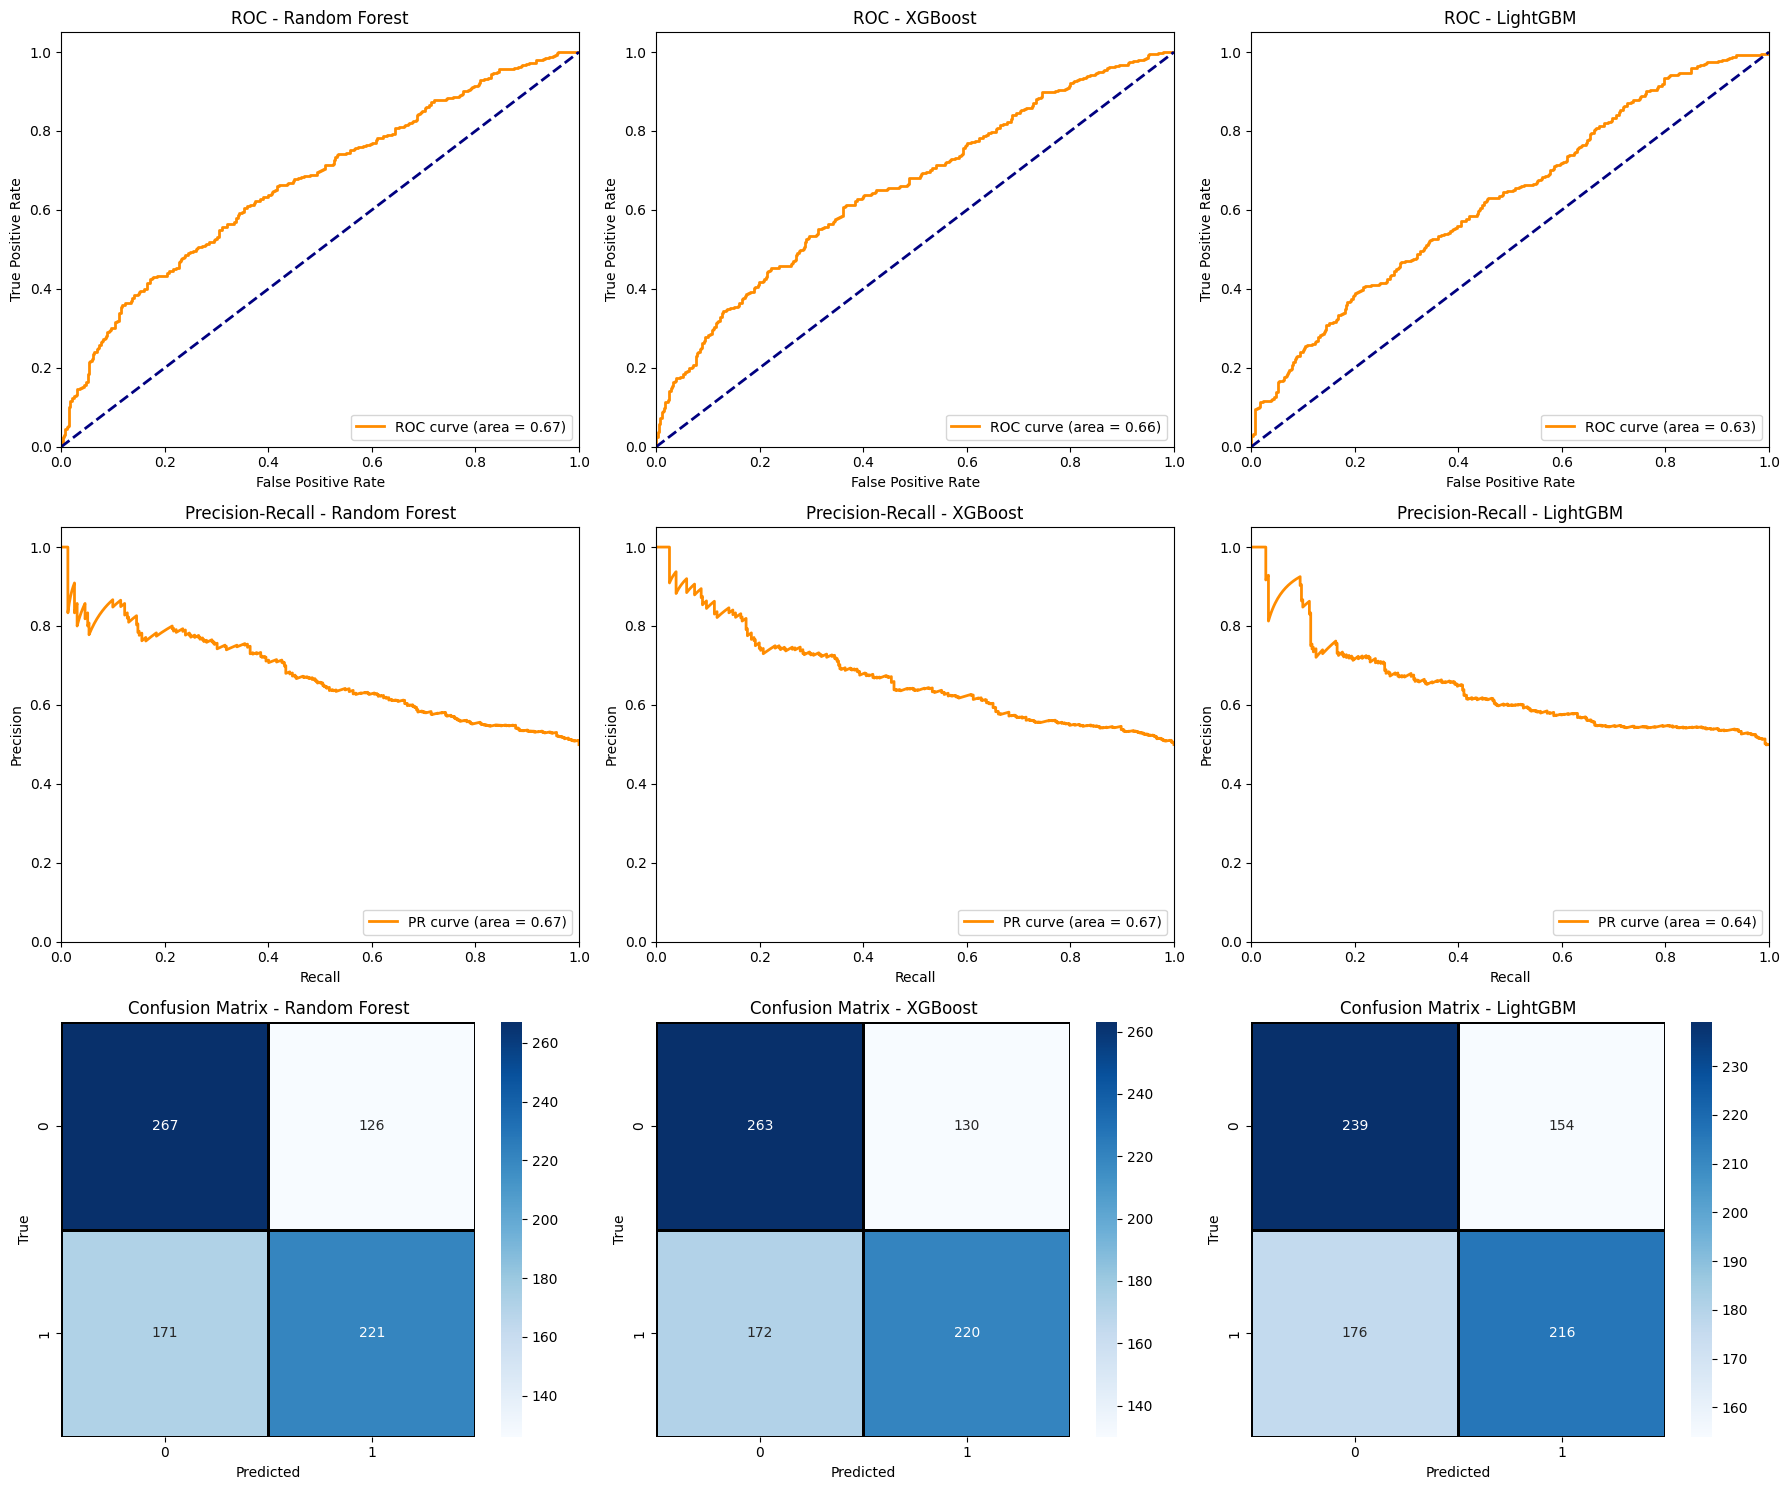

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_all_metrics(models, X_test, y_test, model_names):
    fig, axes = plt.subplots(nrows=3, ncols=len(models), figsize=(18, 15))
    
    for i, model in enumerate(models):
        # ROC Curve
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        axes[0, i].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        axes[0, i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[0, i].set_xlim([0.0, 1.0])
        axes[0, i].set_ylim([0.0, 1.05])
        axes[0, i].set_xlabel('False Positive Rate')
        axes[0, i].set_ylabel('True Positive Rate')
        axes[0, i].set_title(f'ROC - {model_names[i]}')
        axes[0, i].legend(loc="lower right")
        
        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall, precision)
        axes[1, i].plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
        axes[1, i].set_xlim([0.0, 1.0])
        axes[1, i].set_ylim([0.0, 1.05])
        axes[1, i].set_xlabel('Recall')
        axes[1, i].set_ylabel('Precision')
        axes[1, i].set_title(f'Precision-Recall - {model_names[i]}')
        axes[1, i].legend(loc="lower right")
        
        # Confusion Matrix
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black', ax=axes[2, i])
        axes[2, i].set_xlabel('Predicted')
        axes[2, i].set_ylabel('True')
        axes[2, i].set_title(f'Confusion Matrix - {model_names[i]}')

    plt.tight_layout()
    plt.savefig(os.path.join(visual_dir, f'metrics_{trial_number_ml}.png'))
    plt.show()

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
plot_all_metrics(models, X_test, y_test, model_names)


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_roc_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    plt.figure()
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(model, X_test, y_test, model_name='Model'):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
metrics_list = []

def evaluate_model_performance(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba),
    }
    return metrics


# Plotting functions modified to save figures
def plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml):
    for model, model_name in zip(models, model_names):
        # ROC Curve
        plot_roc_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'roc_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Precision-Recall Curve
        plot_precision_recall_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'precision_recall_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Confusion Matrix
        plot_confusion_matrix(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'confusion_matrix_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()



In [12]:
# Evaluate and save metrics for each model
for model, name in zip(models, model_names):
    metrics = evaluate_model_performance(model, X_test, y_test, name)
    metrics_list.append(metrics)
    print(f"Metrics for {name}: {metrics}")

# Convert metrics to DataFrame sort bu 'Accuracy' and save
metrics_df = pd.DataFrame(metrics_list)
sorted_metrics_df = metrics_df.sort_values(by='Accuracy', ascending=False)
sorted_metrics_df.to_csv(os.path.join(results_dir, f'sorted_metrics_df_{trial_number_ml}.csv'), index=False)

Metrics for Random Forest: {'Model': 'Random Forest', 'Accuracy': 0.621656050955414, 'Precision': 0.6368876080691642, 'Recall': 0.5637755102040817, 'F1 Score': 0.5981055480378891, 'ROC AUC': 0.6682959443319312}
Metrics for XGBoost: {'Model': 'XGBoost', 'Accuracy': 0.6152866242038216, 'Precision': 0.6285714285714286, 'Recall': 0.5612244897959183, 'F1 Score': 0.5929919137466307, 'ROC AUC': 0.6564950407643975}
Metrics for LightGBM: {'Model': 'LightGBM', 'Accuracy': 0.5796178343949044, 'Precision': 0.5837837837837838, 'Recall': 0.5510204081632653, 'F1 Score': 0.5669291338582677, 'ROC AUC': 0.6285571480500598}


In [13]:
metrics

{'Model': 'LightGBM',
 'Accuracy': 0.5796178343949044,
 'Precision': 0.5837837837837838,
 'Recall': 0.5510204081632653,
 'F1 Score': 0.5669291338582677,
 'ROC AUC': 0.6285571480500598}

In [14]:
# Assuming you have a list called metrics_list which contains the metrics dictionaries for each model
# And assuming each dictionary has a 'Model' key with the model's name and an 'Accuracy' key with its accuracy

# Extract accuracy scores and model names from metrics_list
accuracy_scores = [metrics['Accuracy'] for metrics in metrics_list]
model_names = [metrics['Model'] for metrics in metrics_list]

# Find the index of the highest accuracy
best_model_index = accuracy_scores.index(max(accuracy_scores))

# Retrieve the best model and its name using the index
best_model = models[best_model_index]
best_model_name = model_names[best_model_index]

# Print the best model name and its accuracy
print(f"Best Model: {best_model_name} with Accuracy: {accuracy_scores[best_model_index]:.4f}")


Best Model: Random Forest with Accuracy: 0.6217


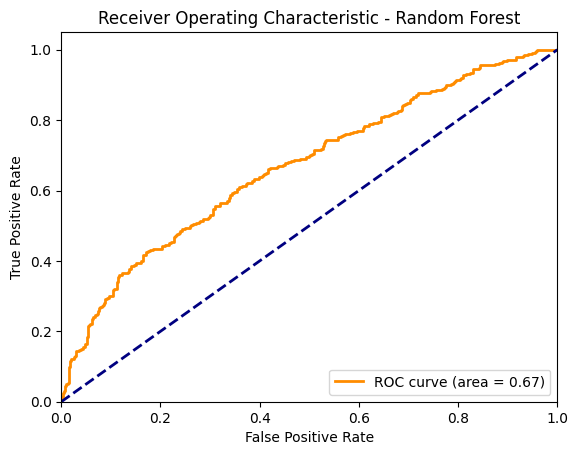

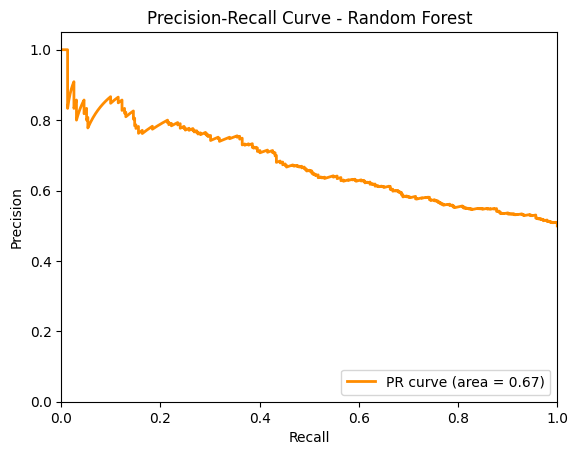

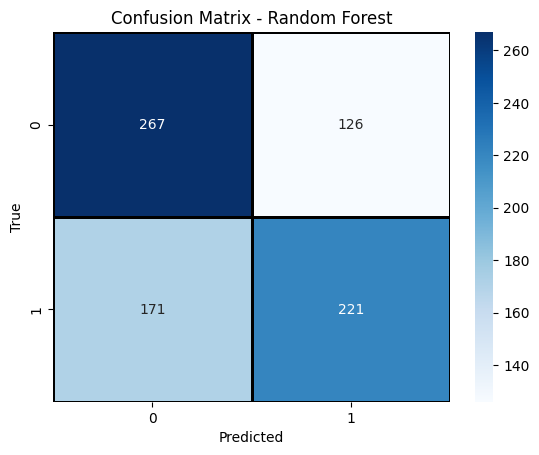

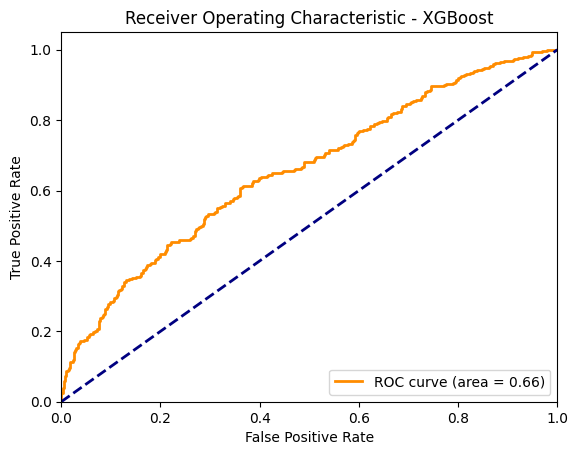

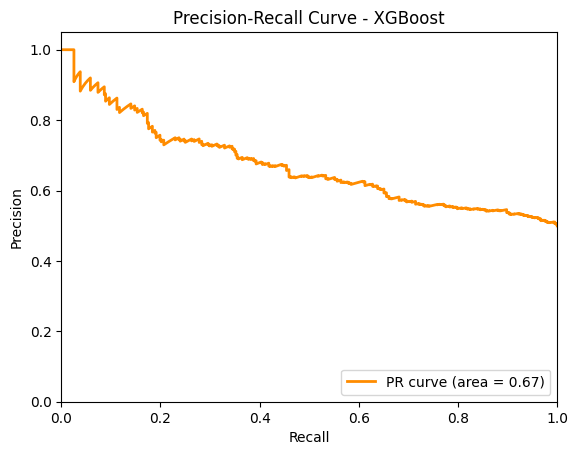

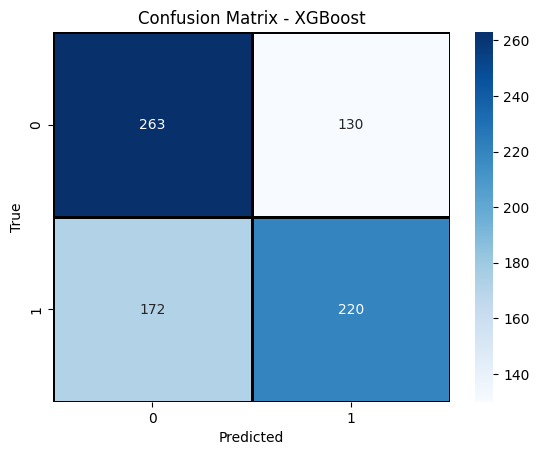

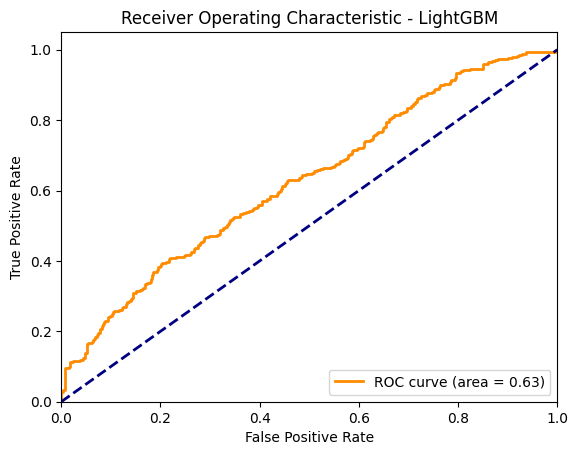

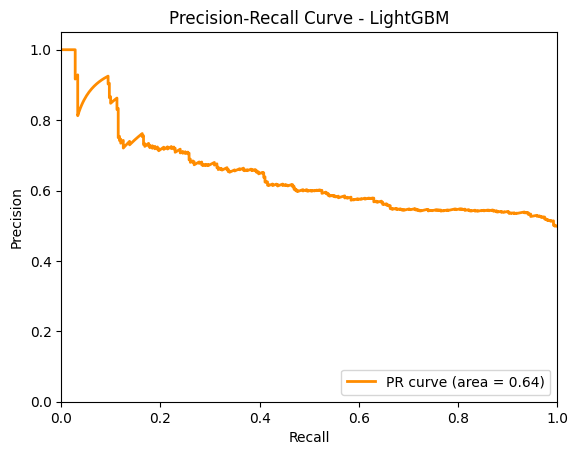

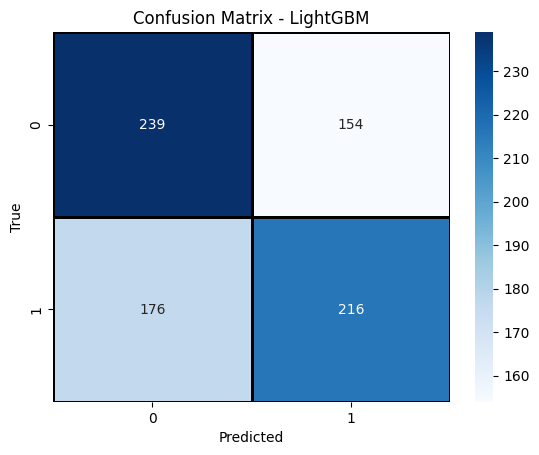

In [15]:
plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml)


In [16]:
def extract_feature_importances(model, feature_names):
    """
    Extract and sort the feature importances from the model.
    """
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]
    return feature_names[sorted_idx], feature_importances[sorted_idx]

def plot_feature_importances(feature_names, feature_importances, title='Feature Importances', n_features=20):
    """
    Visualize the top N feature importances for interpretability.
    """
    plt.figure(figsize=(10, 8))
    sns.barplot(x=feature_importances[:n_features], y=feature_names[:n_features], orient='h')
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature (Bit Index)')
    plt.savefig(os.path.join(features_dir, f'feature_importances_{trial_number_ml}.png'), dpi=300)
    plt.show()

def identify_important_features(feature_names, feature_importances, threshold=0.002):
    """
    Identify features with importance greater than a specified threshold.
    """
    return feature_names[feature_importances > threshold], feature_importances[feature_importances > threshold]

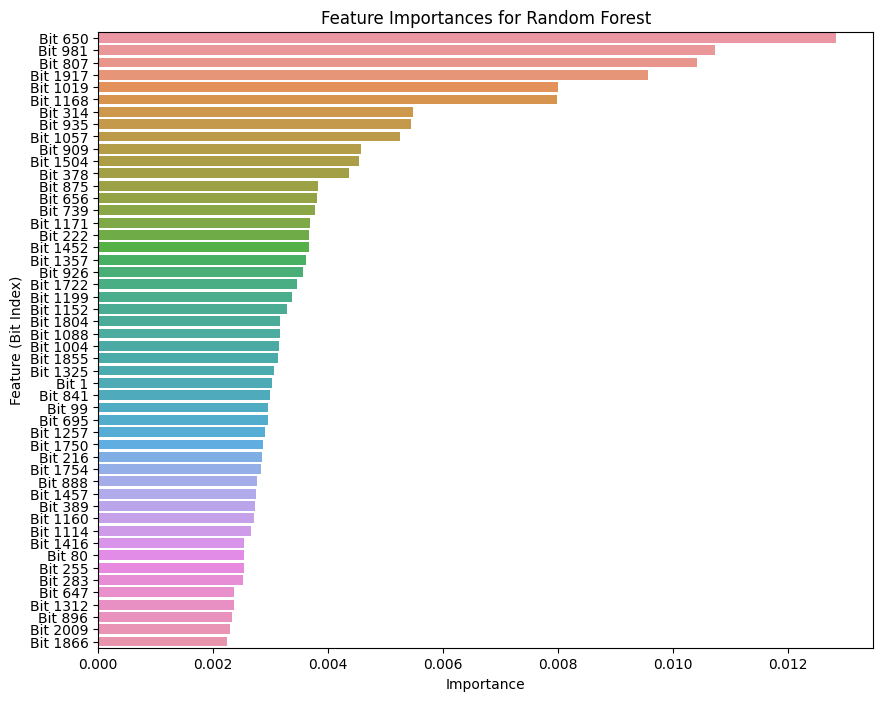

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib

feature_names = np.array(["Bit " + str(i) for i in range(X_train.shape[1])])  # Adjust based on your X_train


def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Save to CSV
    features_df = pd.DataFrame({
        'Feature': sorted_names,
        'Importance': sorted_importances
    })
    csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}.csv')
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=50)
    plt.close()

save_feature_importances(best_model, feature_names, best_model_name, trial_number_ml)


In [18]:
import time

def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Define file paths
    timestamp = time.strftime("%Y%m%d-%H%M%S")  # Current timestamp
    csv_filename = f'feature_importances_{model_name}_{trial_number}.csv'
    plot_filename = f'feature_importances_plot_{model_name}_{trial_number}.png'
    
    # Check if files exist and append timestamp to avoid overwriting
    csv_path = os.path.join(features_dir, csv_filename)
    if os.path.exists(csv_path):
        csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}_{timestamp}.csv')
    
    plot_path = os.path.join(features_dir, plot_filename)
    if os.path.exists(plot_path):
        plot_path = os.path.join(features_dir, f'feature_importances_plot_{model_name}_{trial_number}_{timestamp}.png', dpi=300)

    # Save to CSV
    features_df = pd.DataFrame({'Feature': sorted_names, 'Importance': sorted_importances})
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=20)
    plt.savefig(plot_path)
    plt.close()
